# Загрузка датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [3]:
data = pd.read_csv('Kharovsklesprom_data(1).csv', index_col=0, parse_dates=['Date'])
data.head()

,Date,Time,Usage_kWh
0,2017-01-01,00 - 01,570.685479
1,2017-01-01,01 - 02,604.642705
2,2017-01-01,02 - 03,518.732113
3,2017-01-01,03 - 04,608.188829
4,2017-01-01,04 - 05,714.140572


In [4]:
data.tail()

,Date,Time,Usage_kWh
35059,2020-12-31,19 - 20,1093.896979
35060,2020-12-31,20 - 21,976.242006
35061,2020-12-31,21 - 22,960.551132
35062,2020-12-31,22 - 23,694.074945
35063,2020-12-31,23 - 00,801.715216


In [5]:
y_test = data.iloc[-24*7:]['Usage_kWh'].values

In [6]:
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [152]:
df_results = pd.DataFrame(None,
                      columns=['Model', 'Tuner', 'Params',
                               'MAPE', 'MSE', 'MAE', 'R2', #'Sum',
                               'Training_time', 'Tuner_time', 'Time_prediction'])
df_predictions = pd.DataFrame(None)
df_predictions['True'] = y_test

In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

def r2(y_true, y_pred):
    ssres = sum((y_true-y_pred)**2)
    sstotal = sum((y_true-np.mean(y_true))**2)
    return 1 - ssres/sstotal

In [154]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])

# DecisionTree

In [155]:
model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [156]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [157]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [158]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.04699,28393.766823,127.460416,0.755416,20.022319,None,0.022014


In [159]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])

In [160]:
model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [161]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [162]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [163]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998


In [164]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24*7])

In [165]:
model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [166]:
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

In [167]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000


In [168]:
dates_list = []
for d in data[-24*7:]['Date']:
    if d not in dates_list:
        dates_list.append(d)

In [169]:
dates_list

[Timestamp('2020-12-25 00:00:00'),
 Timestamp('2020-12-26 00:00:00'),
 Timestamp('2020-12-27 00:00:00'),
 Timestamp('2020-12-28 00:00:00'),
 Timestamp('2020-12-29 00:00:00'),
 Timestamp('2020-12-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00')]

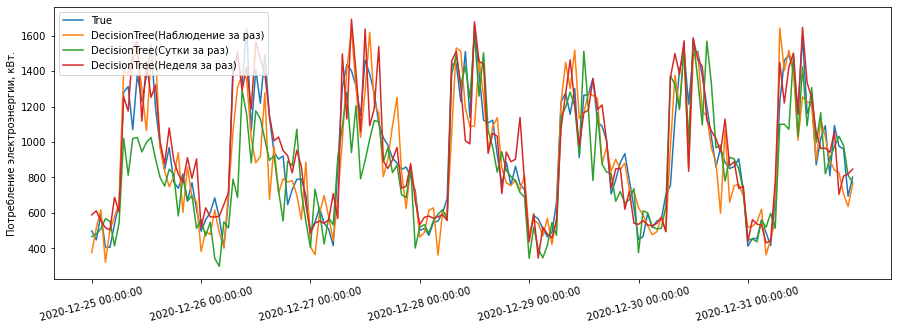

In [170]:
plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [171]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

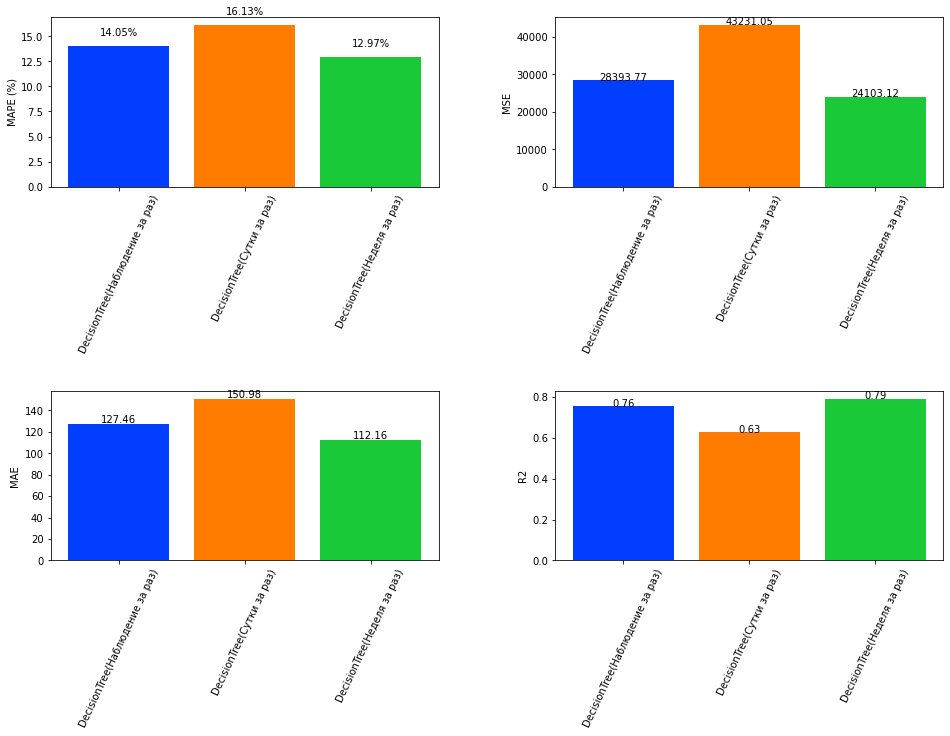

In [172]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

# Random Forest

In [173]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])
    
model_name = 'RandomForest'
params = {'n_estimators':100,
          'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000
3,RandomForest(Наблюдение за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",9.299245,12282.000441,81.881064,0.894203,962.175953,None,1.390336


In [174]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000
3,RandomForest(Наблюдение за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",9.299245,12282.000441,81.881064,0.894203,962.175953,None,1.390336
4,RandomForest(Сутки за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",10.469093,17413.969416,96.522142,0.849996,1976.314166,None,0.171177


In [175]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24*7])
    
model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()
    
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

KeyboardInterrupt: 

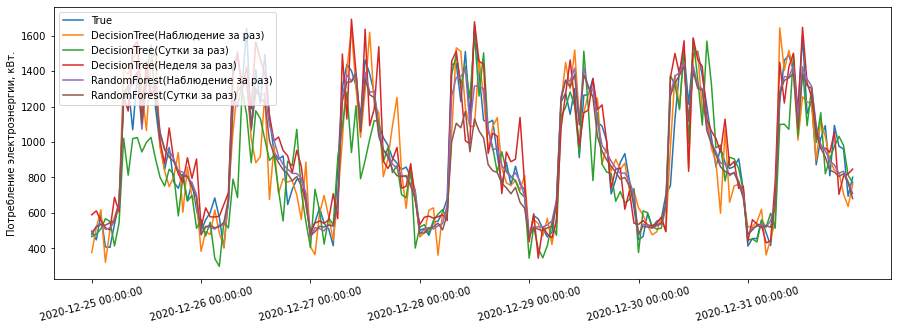

In [192]:
plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [203]:
df_predictions.head()

,True,DecisionTree(Наблюдение за раз),DecisionTree(Сутки за раз),DecisionTree(Неделя за раз),RandomForest(Наблюдение за раз),RandomForest(Сутки за раз)
0,498.574076,376.254520,466.003532,589.542480,476.669955,485.146663
1,448.325927,515.626851,480.716646,611.832702,523.687279,522.738750
2,589.959784,617.725826,509.776000,555.603611,539.426103,533.578030
3,408.063429,321.717925,567.784911,516.897256,507.646790,531.261531
4,406.263067,506.053615,552.295560,503.904770,515.224523,544.928026


In [201]:
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000
3,RandomForest(Наблюдение за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",9.299245,12282.000441,81.881064,0.894203,962.175953,None,1.390336
4,RandomForest(Сутки за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",10.469093,17413.969416,96.522142,0.849996,1976.314166,None,0.171177


In [199]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

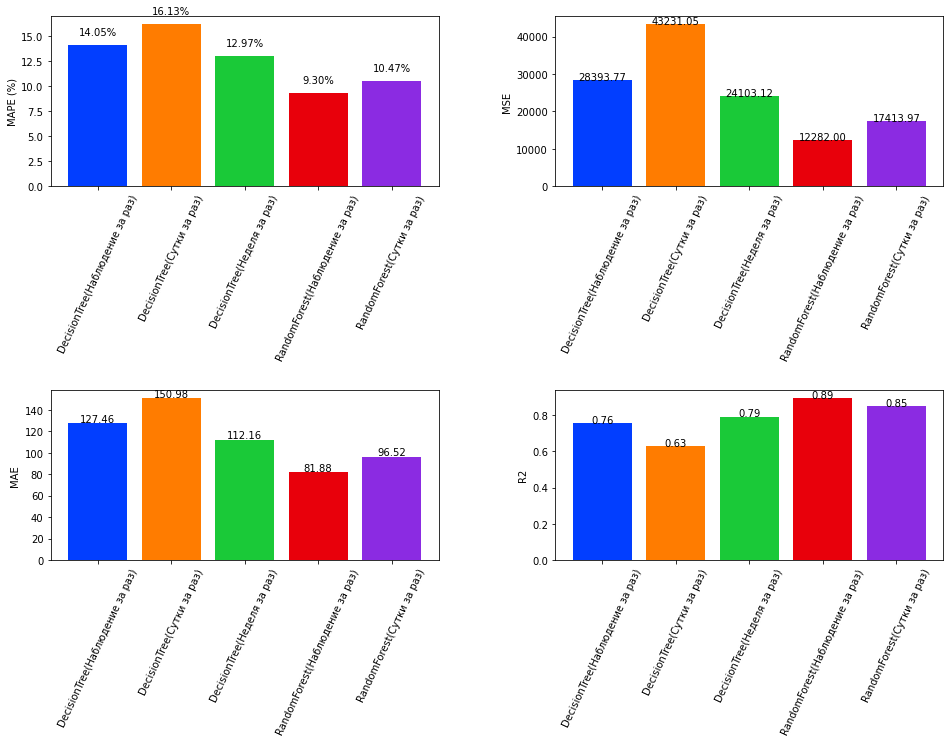

In [200]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

# Стандартизация

# DecisionTree

In [204]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'

# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW]-np.mean(y))/np.std(y))

In [205]:
model_name = 'DecisionTree (стандартизация)'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [206]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [207]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [208]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000
3,RandomForest(Наблюдение за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",9.299245,12282.000441,81.881064,0.894203,962.175953,None,1.390336
4,RandomForest(Сутки за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",10.469093,17413.969416,96.522142,0.849996,1976.314166,None,0.171177
5,DecisionTree (стандартизация)(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",50.282337,161755.224270,334.300832,-0.393359,13.456223,None,0.027239


In [209]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW:i+WINDOW+24]-np.mean(y))/np.std(y))

In [210]:
# model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [211]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [212]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [213]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000
3,RandomForest(Наблюдение за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",9.299245,12282.000441,81.881064,0.894203,962.175953,None,1.390336
4,RandomForest(Сутки за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",10.469093,17413.969416,96.522142,0.849996,1976.314166,None,0.171177
5,DecisionTree (стандартизация)(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",50.282337,161755.224270,334.300832,-0.393359,13.456223,None,0.027239
6,DecisionTree (стандартизация)(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",76.122607,398747.332232,495.601467,-2.434809,46.887068,None,0.000000


In [214]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW:i+WINDOW+24*7]-np.mean(y))/np.std(y))

In [215]:
#model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [216]:
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

In [217]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000
3,RandomForest(Наблюдение за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",9.299245,12282.000441,81.881064,0.894203,962.175953,None,1.390336
4,RandomForest(Сутки за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",10.469093,17413.969416,96.522142,0.849996,1976.314166,None,0.171177
5,DecisionTree (стандартизация)(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",50.282337,161755.224270,334.300832,-0.393359,13.456223,None,0.027239
6,DecisionTree (стандартизация)(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",76.122607,398747.332232,495.601467,-2.434809,46.887068,None,0.000000
7,DecisionTree (стандартизация)(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",64.760475,298990.683946,451.623586,-1.575505,202.951359,None,0.000000


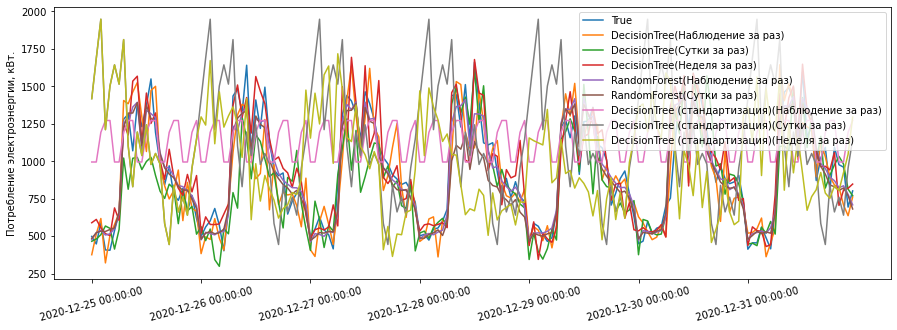

In [218]:
plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [219]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

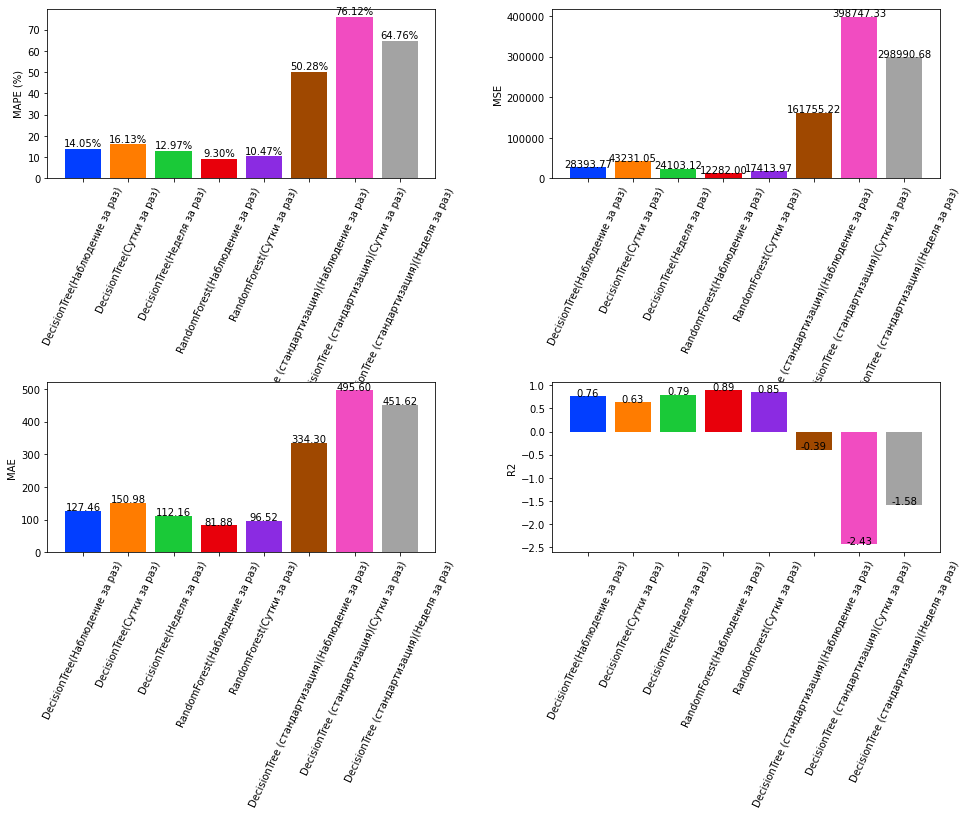

In [220]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

# Нормализация

# DecisionTree

In [221]:
(np.max(y)-np.min(y))

1954.4302401935215

In [232]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'

# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append((y[i:i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))
    y_train.append((y[i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))

In [224]:
model_name = 'DecisionTree (нормализация)'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [225]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [226]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
y_pred = [x * (np.max(y) - np.min(y)) + np.min(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [227]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",14.046990,28393.766823,127.460416,0.755416,20.022319,None,0.022014
1,DecisionTree(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",16.127943,43231.052166,150.975916,0.627608,28.373121,None,0.001998
2,DecisionTree(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",12.971834,24103.124465,112.161936,0.792376,170.405692,None,0.001000
3,RandomForest(Наблюдение за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",9.299245,12282.000441,81.881064,0.894203,962.175953,None,1.390336
4,RandomForest(Сутки за раз),False,"{'n_estimators': 100, 'max_depth': None, 'max_...",10.469093,17413.969416,96.522142,0.849996,1976.314166,None,0.171177
5,DecisionTree (стандартизация)(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",50.282337,161755.224270,334.300832,-0.393359,13.456223,None,0.027239
6,DecisionTree (стандартизация)(Сутки за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",76.122607,398747.332232,495.601467,-2.434809,46.887068,None,0.000000
7,DecisionTree (стандартизация)(Неделя за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",64.760475,298990.683946,451.623586,-1.575505,202.951359,None,0.000000
8,DecisionTree (нормализация)(Наблюдение за раз),False,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",53.446900,170566.829726,352.438594,-0.469263,15.797010,None,0.025001


In [236]:
df_results.to_csv('Trees_results.csv')
df_predictions.to_csv('Trees_predictions.csv')